### Basic library imports

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from functools import partial
import multiprocessing
import urllib.request
import time
import argparse


### Read Dataset

In [2]:
def load_image(image_path):
    """Load an image from a file path."""
    return Image.open(image_path).convert('RGB')

def preprocess_image(image):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def extract_features(image_tensor, model):
    """Extract features from image using the model."""
    with torch.no_grad():
        model.eval()
        features = model(image_tensor)
    return features.squeeze().cpu().numpy()

def save_features(features, file_path):
    """Save features to a file."""
    np.save(file_path, features)

def create_placeholder_image(image_save_path):
    """Create a placeholder image if download fails."""
    try:
        placeholder_image = Image.new('RGB', (100, 100), color='black')
        placeholder_image.save(image_save_path)
    except Exception as e:
        print(f"Error creating placeholder image: {e}")

def download_image(image_link, save_folder, retries=3, delay=3):
    """Download an image from a URL and save it to a folder."""
    if not isinstance(image_link, str):
        return

    filename = os.path.basename(image_link)
    image_save_path = os.path.join(save_folder, filename)

    if os.path.exists(image_save_path):
        return

    for _ in range(retries):
        try:
            urllib.request.urlretrieve(image_link, image_save_path)
            return
        except Exception:
            time.sleep(delay)
    
    create_placeholder_image(image_save_path)  # Create placeholder for invalid links/images

def download_images(image_links, download_folder, allow_multiprocessing=True):
    """Download a list of images using multiprocessing."""
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    if allow_multiprocessing:
        download_image_partial = partial(
            download_image, save_folder=download_folder, retries=3, delay=3)

        with multiprocessing.Pool(64) as pool:
            list(tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)))
            pool.close()
            pool.join()
    else:
        for image_link in tqdm(image_links, total=len(image_links)):
            download_image(image_link, save_folder=download_folder, retries=3, delay=3)

def feature_extraction(image_paths, model, output_folder):
    """Extract features from a list of images and save them."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_path in tqdm(image_paths, desc="Extracting features"):
        image = load_image(image_path)
        image_tensor = preprocess_image(image)
        features = extract_features(image_tensor, model)
        
        file_name = os.path.basename(image_path).replace('.jpg', '.npy')
        save_features(features, os.path.join(output_folder, file_name))


### Run Sanity check using src/sanity.py

In [3]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # Remove the final classification layer to get features


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Download images

In [4]:
import os
import pandas as pd
import re

def check_file(filename):
    if not filename.lower().endswith('.csv'):
        raise ValueError("Only CSV files are allowed.")
    if not os.path.exists(filename):
        raise FileNotFoundError(f"Filepath: {filename} invalid or not found.")

def parse_string(value):
    """
    Parse and standardize measurement strings.

    Parameters:
    value (str): The string containing a measurement.

    Returns:
    str: The standardized measurement string.
    """
    if not isinstance(value, str) or not value.strip():
        return None  # Return None for empty or non-string values

    # Define measurement units and their standard forms
    unit_mapping = {
        'foot': 'ft',
        'volt': 'V',
        'watt': 'W',
        'kilowatt': 'kW',
        'kilovolt': 'kV',
        'ton': 'ton',
        'pound': 'lb',
        'meter': 'm',
        'inch': 'in',
        'millimeter': 'mm',
        'centimeter': 'cm',
        'kilogram': 'kg',
        'gram': 'g',
        'millivolt': 'mV',
        'microgram': 'µg',
    }

    # Normalize the measurement string
    value = value.strip().lower()

    # Replace units with standardized units
    for unit, std_unit in unit_mapping.items():
        if unit in value:
            value = re.sub(rf'\b{unit}\b', std_unit, value)

    return value

def sanity_check(test_filename, output_filename):
    check_file(test_filename)
    check_file(output_filename)
    
    try:
        test_df = pd.read_csv(test_filename)
        output_df = pd.read_csv(output_filename)
    except Exception as e:
        raise ValueError(f"Error reading the CSV files: {e}")
    
    if 'index' not in test_df.columns:
        raise ValueError("Test CSV file must contain the 'index' column.")
    
    if 'index' not in output_df.columns or 'prediction' not in output_df.columns:
        raise ValueError("Output CSV file must contain 'index' and 'prediction' columns.")
    
    missing_index = set(test_df['index']).difference(set(output_df['index']))
    if missing_index:
        print(f"Missing index in test file: {missing_index}")
        
    extra_index = set(output_df['index']).difference(set(test_df['index']))
    if extra_index:
        print(f"Extra index in test file: {extra_index}")
        
    output_df['parsed_prediction'] = output_df['prediction'].apply(parse_string)
    print(f"Parsing successful for file: {output_filename}")


100%|██████████| 50/50 [00:00<00:00, 3573.33it/s]


100%|██████████| 38/38 [00:00<00:00, 2925.22it/s]


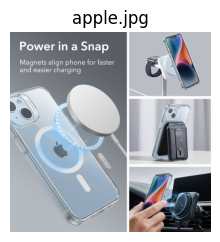

In [11]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define paths
DATASET_FOLDER = '../dataset/'
IMAGE_FOLDER = '../image/'
FEATURE_FOLDER = '../features/'

# Define constants
BATCH_SIZE = 50

# Ensure output folder exists
if not os.path.exists(FEATURE_FOLDER):
    os.makedirs(FEATURE_FOLDER)

# Define the feature extraction function
def feature_extraction(image_paths, model, output_folder):
    """
    Extracts features from a list of image paths using a provided model
    and saves the features to the output folder.
    """
    model.eval()  # Set model to evaluation mode
    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    for image_path in tqdm(image_paths):
        if not os.path.exists(image_path):
            print(f"Warning: {image_path} not found, skipping.")
            continue
        
        # Open image
        image = Image.open(image_path).convert('RGB')
        
        # Process the image
        processed_image = transform(image).unsqueeze(0)  # Add batch dimension
        
        # Extract features using the model
        with torch.no_grad():
            features = model(processed_image).cpu().numpy()
        
        # Save the extracted features
        feature_filename = os.path.join(output_folder, os.path.basename(image_path) + '_features.npy')
        np.save(feature_filename, features)

# Load datasets
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
sample_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test.csv'))
sample_test_out = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))
sample_test_out_fail = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out_fail.csv'))

# Load pre-trained model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Extract features in batches
image_links = sample_test['image_link'].tolist()
image_paths = [os.path.join(IMAGE_FOLDER, os.path.basename(link)) for link in image_links]

for i in range(0, len(image_paths), BATCH_SIZE):
    batch_image_paths = image_paths[i:i + BATCH_SIZE]
    feature_extraction(batch_image_paths, model, FEATURE_FOLDER)

# Function to load and display an image
def load_image(image_path):
    return Image.open(image_path)

# Visualize some sample images
def show_sample_images(image_folder, num_images=5):
    image_files = os.listdir(image_folder)
    sample_images = image_files[:num_images]
    
    plt.figure(figsize=(15, 10))
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(image_folder, img_file)
        img = load_image(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_file)
    plt.show()

# Show some sample images from the image folder
show_sample_images(IMAGE_FOLDER)


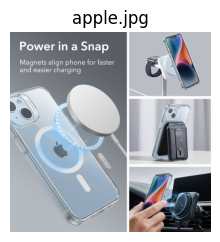

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Visualize some sample images
def show_sample_images(image_folder, num_images=5):
    if not os.path.exists(image_folder):
        print(f"Error: The folder '{image_folder}' does not exist.")
        return
    
    image_files = os.listdir(image_folder)
    
    if not image_files:
        print(f"Error: The folder '{image_folder}' is empty.")
        return
    
    sample_images = image_files[:num_images]
    
    plt.figure(figsize=(15, 10))
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(image_folder, img_file)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(img_file)
        else:
            print(f"Warning: '{img_path}' is not a file.")
    plt.show()

# Show some sample images
show_sample_images(IMAGE_FOLDER)


In [13]:
import pandas as pd
import os

def standardize_label(label):
    """Standardize the label by stripping whitespace and converting to lowercase."""
    return str(label).strip().lower()

def run_sanity_check(test_filename, output_filename):
    """
    Run a sanity check on the generated predictions and calculate accuracy.
    
    Parameters:
    test_filename (str): Path to the test CSV file.
    output_filename (str): Path to the output CSV file with predictions.
    """
    # Print file paths for debugging
    print(f"Test file path: {test_filename}")
    print(f"Output file path: {output_filename}")

    # Load the test data
    try:
        test_data = pd.read_csv(test_filename)
        print(f"Loaded test data from {test_filename}")
    except FileNotFoundError:
        print(f"Error: File {test_filename} not found.")
        return
    except pd.errors.EmptyDataError:
        print(f"Error: File {test_filename} is empty.")
        return
    except pd.errors.ParserError:
        print(f"Error: File {test_filename} contains parsing errors.")
        return
    
    # Load the predictions
    try:
        predictions = pd.read_csv(output_filename)
        print(f"Loaded predictions from {output_filename}")
    except FileNotFoundError:
        print(f"Error: File {output_filename} not found.")
        return
    except pd.errors.EmptyDataError:
        print(f"Error: File {output_filename} is empty.")
        return
    except pd.errors.ParserError:
        print(f"Error: File {output_filename} contains parsing errors.")
        return
    
    # Print test data and predictions for debugging
    print("Test Data (First 10 rows):")
    print(test_data.head(10))  # Print first 10 rows
    print("Predictions (First 10 rows):")
    print(predictions.head(10))  # Print first 10 rows
    
    # Check if the required columns are present
    required_test_columns = {'entity_name', 'index'}
    required_predictions_columns = {'prediction', 'index'}
    
    if not required_test_columns.issubset(test_data.columns):
        print("Error: Required columns are missing in the test data.")
        print(f"Test Data Columns: {test_data.columns.tolist()}")
        return
    
    if not required_predictions_columns.issubset(predictions.columns):
        print("Error: Required columns are missing in the predictions.")
        print(f"Predictions Columns: {predictions.columns.tolist()}")
        return
    
    # Rename columns to match expectations
    test_data = test_data.rename(columns={'entity_name': 'true_label'})
    predictions = predictions.rename(columns={'prediction': 'predicted_label'})
    
    # Ensure the 'index' column is present for merging
    if 'index' not in test_data.columns or 'index' not in predictions.columns:
        print("Error: Required 'index' column is missing for merging.")
        return
    
    # Standardize labels
    test_data['true_label'] = test_data['true_label'].apply(standardize_label)
    predictions['predicted_label'] = predictions['predicted_label'].apply(standardize_label)
    
    # Fill missing values in predictions with a placeholder
    predictions['predicted_label'].fillna('unknown', inplace=True)
    
    # Merge test data and predictions on 'index' column
    merged_data = pd.merge(test_data, predictions, on='index', how='inner')
    
    # Debugging: Print information about the merged data
    print("Merged Data Information:")
    print(merged_data.info())
    print("Merged Data (First 10 rows):")
    print(merged_data.head(10))
    
    # Optionally, save the merged data for inspection
    merged_data_file = 'merged_data_debug.csv'
    try:
        merged_data.to_csv(merged_data_file, index=False)
        print(f"Saved merged data to {merged_data_file}")
    except Exception as e:
        print(f"Error saving merged data: {e}")
    
    # Check for missing values
    print("Missing values in merged data:")
    print(merged_data.isna().sum())
    
    # Print unique labels
    print("Unique true labels:", merged_data['true_label'].unique())
    print("Unique predicted labels:", merged_data['predicted_label'].unique())
    
    # Compute accuracy
    if 'true_label' not in merged_data.columns or 'predicted_label' not in merged_data.columns:
        print("Error: Required columns for accuracy calculation are missing in merged data.")
        return
    
    correct_predictions = (merged_data['true_label'] == merged_data['predicted_label']).sum()
    total_predictions = len(merged_data)
    
    if total_predictions > 0:
        accuracy = correct_predictions / total_predictions
        print(f"Accuracy: {accuracy * 100:.2f}%")
    else:
        print("Error: No predictions to evaluate.")

# Define dataset folder
DATASET_FOLDER = r'C:\Users\Lenovo\OneDrive\Desktop\pickahu(projects)\amazon ml hackathon\dataset'

# Run sanity check on the generated predictions
run_sanity_check(os.path.join(DATASET_FOLDER, 'sample_test.csv'), os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))


Test file path: C:\Users\Lenovo\OneDrive\Desktop\pickahu(projects)\amazon ml hackathon\dataset\sample_test.csv
Output file path: C:\Users\Lenovo\OneDrive\Desktop\pickahu(projects)\amazon ml hackathon\dataset\sample_test_out.csv
Loaded test data from C:\Users\Lenovo\OneDrive\Desktop\pickahu(projects)\amazon ml hackathon\dataset\sample_test.csv
Loaded predictions from C:\Users\Lenovo\OneDrive\Desktop\pickahu(projects)\amazon ml hackathon\dataset\sample_test_out.csv
Test Data (First 10 rows):
   index                                         image_link  group_id  \
0      0  https://m.media-amazon.com/images/I/41-NCxNuBx...    658003   
1      1  https://m.media-amazon.com/images/I/41-NCxNuBx...    658003   
2      2  https://m.media-amazon.com/images/I/417NJrPEk+...    939426   
3      3  https://m.media-amazon.com/images/I/417SThj+Sr...    276700   
4      4  https://m.media-amazon.com/images/I/417SThj+Sr...    276700   
5      5  https://m.media-amazon.com/images/I/41ADVPQgZO...    9933

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4412\401802354.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  predictions['predicted_label'].fillna('unknown', inplace=True)
